In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
DATA_DIR = 'datasets/lastfm-dataset-360K/'

In [3]:
df = pd.read_csv(DATA_DIR + 'usersha1-artmbid-artname-plays.tsv', sep='\t', header=None)

In [4]:
df.head()

,0,1,2,3
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706


In [5]:
from pyspark.sql import SparkSession

spark = (
    SparkSession
    .builder
    .config('spark.driver.memory', '8G')
    .config('spark.sql.analyzer.failAmbiguousSelfJoin', 'False')
    .master('local[*]')
    .getOrCreate()
)

In [6]:
import os
import pyspark.sql.functions as sql_func

plays = (
    spark
    .read
    .csv(
        os.path.join(DATA_DIR, 'usersha1-artmbid-artname-plays.tsv'),
        header=False,
        inferSchema=True,
        sep='\t'
    )
    .sample(withReplacement=False, fraction=1.0, seed=42)
    # имена колонкам можно узнать из файла README.txt
    .toDF('user', 'artist', 'artist_name', 'plays')
    .cache()
)

In [7]:
# этот набор данных гораздо более разреженный, чем movielens
total_users = plays.select('user').distinct().count()
total_artists = plays.select('artist_name').distinct().count()
total_samples = plays.count()
print('Всего пользователей: ', total_users)
print('Всего исполнителей: ', total_artists)
print('Всего пар пльзователь - исполнитель: ', total_samples)
print('Процент ненулевых пар: ', total_samples / total_users / total_artists)

Всего пользователей:  359349
Всего исполнителей:  292577
Всего пар пльзователь - исполнитель:  17559530
Процент ненулевых пар:  0.00016701530241348985


In [8]:
# в отличии от movielens количество прослущшиваний имеет гораздо больший размах
plays.select('plays').describe().show()

+-------+------------------+
|summary|             plays|
+-------+------------------+
|  count|          17559518|
|   mean|215.18542764100928|
| stddev|   614.44796397153|
|    min|               0.0|
|    max|          419157.0|
+-------+------------------+



In [9]:
# есть какие-то поользователи, совершившие меньше отдного прослушивания
plays.where('plays < 1').show(truncate=False)

+----------------------------------------+------+-----------+-----+
|user                                    |artist|artist_name|plays|
+----------------------------------------+------+-----------+-----+
|cbec2d2763c856034f5689ba13ca8addb9d24984|null  |28         |0.0  |
+----------------------------------------+------+-----------+-----+



In [10]:
# смотрим на распределение длин идентификаторов
plays.select(sql_func.length('artist').alias('1')).distinct().orderBy('1').show()

+----+
|   1|
+----+
|null|
|   2|
|   3|
|  15|
|  35|
|  36|
|  37|
+----+



In [11]:
# исполнители курильщика
plays.where('LENGTH(artist) < 35').select('artist', 'artist_name').distinct().show()

+---------------+--------------+
|         artist|   artist_name|
+---------------+--------------+
|            211| 000 promises.|
|rock / a30a400a|blind the fold|
|            313|    000 things|
|             96|    000 things|
+---------------+--------------+



In [12]:
#  исполнители здорового человека
plays.where('LENGTH(artist) >= 35').select('artist', 'artist_name').distinct().show(truncate=False, n=5)

+------------------------------------+---------------------+
|artist                              |artist_name          |
+------------------------------------+---------------------+
|8bfac288-ccc5-448d-9573-c33ea2aa5c30|red hot chili peppers|
|1595addf-f76b-450a-a097-af852ff35f27|nujabes              |
|7e482754-d3f6-49e5-b351-235849754e26|tristania            |
|5bb2a9c8-3505-4c45-9717-19f0f8f35425|orgy                 |
|ef6e2e49-aa93-41bd-89b0-8c7d2f260a83|lostprophets         |
+------------------------------------+---------------------+
only showing top 5 rows



In [13]:
# аналогичные странности есть с ID пользователя
plays.select(sql_func.length('user')).distinct().show()

+------------+
|length(user)|
+------------+
|          12|
|          40|
+------------+



In [14]:
# идентифиакторы длины 12 выглядят странно
plays.where('LENGTH(user) == 12').select('user').distinct().show()

+------------+
|        user|
+------------+
|sep 20, 2008|
|dec 27, 2008|
+------------+



In [15]:
# будем в дальнейшем использовать очищенное множество
pure_plays = (
    plays
    .where('LENGTH(artist) >= 35 AND LENGTH(user) == 40')
    .cache()
)
pure_plays.select('plays').describe().show()

+-------+-----------------+
|summary|            plays|
+-------+-----------------+
|  count|         17332977|
|   mean|216.0470919681022|
| stddev| 616.996942719551|
|    min|              1.0|
|    max|         419157.0|
+-------+-----------------+



In [16]:
# для неявной оьратной связи в таком виде обычно хорошо работает
# логарифмическая шкала
pure_plays.select(sql_func.log('plays')).describe().show()

+-------+------------------+
|summary|         ln(plays)|
+-------+------------------+
|  count|          17332977|
|   mean| 4.426035251429405|
| stddev|1.4618746810751015|
|    min|               0.0|
|    max| 12.94600083039178|
+-------+------------------+



<AxesSubplot:xlabel='bucket'>

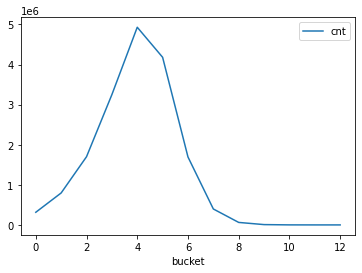

In [17]:
# распределение логарифма количества прослушиваний
(
    pure_plays
    .select(sql_func.floor(sql_func.log('plays')).alias('bucket'))
    .groupBy('bucket')
    .agg(sql_func.count('bucket').alias('cnt'))
    .orderBy('bucket')
    .toPandas()
    .plot(x='bucket', y='cnt')
    
)

In [18]:
# выберем самых популярных испольнителей
top_artists = (
    pure_plays
    .groupBy('artist', 'artist_name')
    .agg(sql_func.sum('plays').alias('total_plays'))
    .orderBy(sql_func.desc('total_plays'))
    .limit(100)
    .toPandas()
)
top_artists.head()

,artist,artist_name,total_plays
0,b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d,the beatles,30499140.0
1,a74b1b7f-71a5-4011-9441-d0b5e4122711,radiohead,27452124.0
2,cc197bad-dc9c-440d-a5b5-d52ba2e14234,coldplay,16701858.0
3,83d91898-7763-47d7-b03b-b92132375c47,pink floyd,15965959.0
4,65f4f0c5-ef9e-490c-aee3-909e7ae6b2ab,metallica,15498759.0


In [19]:
# посчитаем hitrate@N
def hitrate_at_n(n: int) -> float:
    return (
        pure_plays
        .join(
            sql_func.broadcast(spark.createDataFrame(top_artists[:n])),
            on='artist',
            how='left'
        )
        .groupBy('user')
        .agg(sql_func.max('total_plays').alias('some_plays'))
        .select(
            sql_func.col('user'),
            sql_func.when(sql_func.col('some_plays').isNotNull(), 1).otherwise(0).alias('hit')
        )
        .agg(sql_func.avg('hit').alias('hit_rate'))
        .first()[0]
    )

In [26]:
# чем больше элементов мы можем порекомфендовать, тем лучше метрики
for n in [100, 50, 20, 10, 5, 1]:
    print('hitrate{} = {}'.format(n, hitrate_at_n(n)))

Py4JJavaError: An error occurred while calling o299.collectToPython.
: org.apache.spark.sql.catalyst.errors.package$TreeNodeException: execute, tree:
Exchange SinglePartition, ENSURE_REQUIREMENTS, [id=#533]
+- *(3) HashAggregate(keys=[], functions=[partial_avg(cast(hit#1710 as bigint))], output=[sum#1780, count#1781L])
   +- *(3) HashAggregate(keys=[user#24], functions=[max(total_plays#1690)], output=[hit#1710])
      +- Exchange hashpartitioning(user#24, 200), ENSURE_REQUIREMENTS, [id=#528]
         +- *(2) HashAggregate(keys=[user#24], functions=[partial_max(total_plays#1690)], output=[user#24, max#1783])
            +- *(2) Project [user#24, total_plays#1690]
               +- *(2) BroadcastHashJoin [artist#25], [artist#1688], LeftOuter, BuildRight, false
                  :- InMemoryTableScan [user#24, artist#25]
                  :     +- InMemoryRelation [user#24, artist#25, artist_name#26, plays#27], StorageLevel(disk, memory, deserialized, 1 replicas)
                  :           +- *(1) Filter (((isnotnull(artist#25) AND isnotnull(user#24)) AND (length(artist#25) >= 35)) AND (length(user#24) = 40))
                  :              +- InMemoryTableScan [user#24, artist#25, artist_name#26, plays#27], [isnotnull(artist#25), isnotnull(user#24), (length(artist#25) >= 35), (length(user#24) = 40)]
                  :                    +- InMemoryRelation [user#24, artist#25, artist_name#26, plays#27], StorageLevel(disk, memory, deserialized, 1 replicas)
                  :                          +- *(1) Project [_c0#16 AS user#24, _c1#17 AS artist#25, _c2#18 AS artist_name#26, _c3#19 AS plays#27]
                  :                             +- *(1) Sample 0.0, 1.0, false, 42
                  :                                +- FileScan csv [_c0#16,_c1#17,_c2#18,_c3#19] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/C:/Users/adwiz/Documents/Courses/datascience_netology/datasets/lastfm-dat..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<_c0:string,_c1:string,_c2:string,_c3:double>
                  +- BroadcastExchange HashedRelationBroadcastMode(List(input[0, string, true]),false), [id=#522]
                     +- *(1) Project [artist#1688, total_plays#1690]
                        +- *(1) Filter isnotnull(artist#1688)
                           +- *(1) Scan ExistingRDD[artist#1688,artist_name#1689,total_plays#1690]

	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:56)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.doExecute(ShuffleExchangeExec.scala:163)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.InputAdapter.inputRDD(WholeStageCodegenExec.scala:525)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs(WholeStageCodegenExec.scala:453)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs$(WholeStageCodegenExec.scala:452)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:496)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.inputRDDs(HashAggregateExec.scala:141)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:746)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:321)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:387)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3519)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3516)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:64)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:564)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:832)
Caused by: org.apache.spark.sql.catalyst.errors.package$TreeNodeException: execute, tree:
Exchange hashpartitioning(user#24, 200), ENSURE_REQUIREMENTS, [id=#528]
+- *(2) HashAggregate(keys=[user#24], functions=[partial_max(total_plays#1690)], output=[user#24, max#1783])
   +- *(2) Project [user#24, total_plays#1690]
      +- *(2) BroadcastHashJoin [artist#25], [artist#1688], LeftOuter, BuildRight, false
         :- InMemoryTableScan [user#24, artist#25]
         :     +- InMemoryRelation [user#24, artist#25, artist_name#26, plays#27], StorageLevel(disk, memory, deserialized, 1 replicas)
         :           +- *(1) Filter (((isnotnull(artist#25) AND isnotnull(user#24)) AND (length(artist#25) >= 35)) AND (length(user#24) = 40))
         :              +- InMemoryTableScan [user#24, artist#25, artist_name#26, plays#27], [isnotnull(artist#25), isnotnull(user#24), (length(artist#25) >= 35), (length(user#24) = 40)]
         :                    +- InMemoryRelation [user#24, artist#25, artist_name#26, plays#27], StorageLevel(disk, memory, deserialized, 1 replicas)
         :                          +- *(1) Project [_c0#16 AS user#24, _c1#17 AS artist#25, _c2#18 AS artist_name#26, _c3#19 AS plays#27]
         :                             +- *(1) Sample 0.0, 1.0, false, 42
         :                                +- FileScan csv [_c0#16,_c1#17,_c2#18,_c3#19] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/C:/Users/adwiz/Documents/Courses/datascience_netology/datasets/lastfm-dat..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<_c0:string,_c1:string,_c2:string,_c3:double>
         +- BroadcastExchange HashedRelationBroadcastMode(List(input[0, string, true]),false), [id=#522]
            +- *(1) Project [artist#1688, total_plays#1690]
               +- *(1) Filter isnotnull(artist#1688)
                  +- *(1) Scan ExistingRDD[artist#1688,artist_name#1689,total_plays#1690]

	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:56)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.doExecute(ShuffleExchangeExec.scala:163)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.InputAdapter.inputRDD(WholeStageCodegenExec.scala:525)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs(WholeStageCodegenExec.scala:453)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs$(WholeStageCodegenExec.scala:452)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:496)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.inputRDDs(HashAggregateExec.scala:141)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.inputRDDs(HashAggregateExec.scala:141)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:746)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.inputRDD$lzycompute(ShuffleExchangeExec.scala:118)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.inputRDD(ShuffleExchangeExec.scala:118)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.shuffleDependency$lzycompute(ShuffleExchangeExec.scala:151)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.shuffleDependency(ShuffleExchangeExec.scala:149)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.$anonfun$doExecute$1(ShuffleExchangeExec.scala:166)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	... 39 more
Caused by: java.util.concurrent.ExecutionException: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 61.0 failed 1 times, most recent failure: Lost task 3.0 in stage 61.0 (TID 2032) (192.168.3.7 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\worker.py", line 473, in main
Exception: Python in worker has different version 3.9 than that in driver 3.8, PySpark cannot run with different minor versions. Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:517)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:652)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:635)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:345)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:898)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:898)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)

Driver stacktrace:
	at java.base/java.util.concurrent.FutureTask.report(FutureTask.java:122)
	at java.base/java.util.concurrent.FutureTask.get(FutureTask.java:205)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec.doExecuteBroadcast(BroadcastExchangeExec.scala:194)
	at org.apache.spark.sql.execution.InputAdapter.doExecuteBroadcast(WholeStageCodegenExec.scala:515)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeBroadcast$1(SparkPlan.scala:193)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.executeBroadcast(SparkPlan.scala:189)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.prepareBroadcast(BroadcastHashJoinExec.scala:203)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.prepareRelation(BroadcastHashJoinExec.scala:217)
	at org.apache.spark.sql.execution.joins.HashJoin.codegenOuter(HashJoin.scala:503)
	at org.apache.spark.sql.execution.joins.HashJoin.codegenOuter$(HashJoin.scala:502)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.codegenOuter(BroadcastHashJoinExec.scala:40)
	at org.apache.spark.sql.execution.joins.HashJoin.doConsume(HashJoin.scala:358)
	at org.apache.spark.sql.execution.joins.HashJoin.doConsume$(HashJoin.scala:355)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.doConsume(BroadcastHashJoinExec.scala:40)
	at org.apache.spark.sql.execution.CodegenSupport.consume(WholeStageCodegenExec.scala:194)
	at org.apache.spark.sql.execution.CodegenSupport.consume$(WholeStageCodegenExec.scala:149)
	at org.apache.spark.sql.execution.InputAdapter.consume(WholeStageCodegenExec.scala:496)
	at org.apache.spark.sql.execution.InputRDDCodegen.doProduce(WholeStageCodegenExec.scala:483)
	at org.apache.spark.sql.execution.InputRDDCodegen.doProduce$(WholeStageCodegenExec.scala:456)
	at org.apache.spark.sql.execution.InputAdapter.doProduce(WholeStageCodegenExec.scala:496)
	at org.apache.spark.sql.execution.CodegenSupport.$anonfun$produce$1(WholeStageCodegenExec.scala:95)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.CodegenSupport.produce(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.CodegenSupport.produce$(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.InputAdapter.produce(WholeStageCodegenExec.scala:496)
	at org.apache.spark.sql.execution.joins.HashJoin.doProduce(HashJoin.scala:352)
	at org.apache.spark.sql.execution.joins.HashJoin.doProduce$(HashJoin.scala:351)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.doProduce(BroadcastHashJoinExec.scala:40)
	at org.apache.spark.sql.execution.CodegenSupport.$anonfun$produce$1(WholeStageCodegenExec.scala:95)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.CodegenSupport.produce(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.CodegenSupport.produce$(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.produce(BroadcastHashJoinExec.scala:40)
	at org.apache.spark.sql.execution.ProjectExec.doProduce(basicPhysicalOperators.scala:54)
	at org.apache.spark.sql.execution.CodegenSupport.$anonfun$produce$1(WholeStageCodegenExec.scala:95)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.CodegenSupport.produce(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.CodegenSupport.produce$(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.ProjectExec.produce(basicPhysicalOperators.scala:41)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.doProduceWithKeys(HashAggregateExec.scala:733)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.doProduce(HashAggregateExec.scala:148)
	at org.apache.spark.sql.execution.CodegenSupport.$anonfun$produce$1(WholeStageCodegenExec.scala:95)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.CodegenSupport.produce(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.CodegenSupport.produce$(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.produce(HashAggregateExec.scala:47)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doCodeGen(WholeStageCodegenExec.scala:655)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:718)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.inputRDD$lzycompute(ShuffleExchangeExec.scala:118)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.inputRDD(ShuffleExchangeExec.scala:118)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.shuffleDependency$lzycompute(ShuffleExchangeExec.scala:151)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.shuffleDependency(ShuffleExchangeExec.scala:149)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.$anonfun$doExecute$1(ShuffleExchangeExec.scala:166)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	... 63 more
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 61.0 failed 1 times, most recent failure: Lost task 3.0 in stage 61.0 (TID 2032) (192.168.3.7 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\worker.py", line 473, in main
Exception: Python in worker has different version 3.9 than that in driver 3.8, PySpark cannot run with different minor versions. Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:517)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:652)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:635)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:345)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:898)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:898)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2445)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2217)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2236)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2261)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.sql.execution.SparkPlan.executeCollectIterator(SparkPlan.scala:397)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec.$anonfun$relationFuture$1(BroadcastExchangeExec.scala:118)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$1(SQLExecution.scala:185)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	... 1 more
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\worker.py", line 473, in main
Exception: Python in worker has different version 3.9 than that in driver 3.8, PySpark cannot run with different minor versions. Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:517)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:652)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:635)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:345)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:898)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:898)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	... 3 more
